In [34]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# Normalize the data

In [36]:
# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('residual sugar')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['residual sugar'].values ).float()
labels = labels[:,None] # transform to matrix

# Split the data 

In [37]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 1
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=batchsize)

# Create The model

In [38]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self, x):
    x = F.relu(self.input(x))
    x = F.relu(self.fc1(x)) # fully connected
    x = F.relu(self.fc2(x))
    return self.output(x) # Pas de fonction d'activation ici pour la régression


# Train the model 

In [39]:
# Global parameters
numepochs = 100

In [40]:
def trainTheModel():
  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(), lr=0.001)
  
  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []
  
  # loop over epochs
  for epochi in range(numepochs):
    # switch on training mode
    winenet.train()
    
    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    
    for X,y in train_loader:
      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat, y)  # Correction ici: utiliser y au lieu de labels
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # loss from this batch
      batchLoss.append(loss.item())
      
      # Pour une régression, calculons l'erreur moyenne au lieu de l'exactitude
      batchAcc.append(torch.mean(torch.abs(yHat-y)).item())
    
    # end of batch loop...
    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append(np.mean(batchAcc))
    
    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)
    
    # test accuracy
    winenet.eval()  # Correction: remplacé winesugar.eval() par winenet.eval()
    
    # Calculer la performance sur tout le jeu de test
    test_loss = 0
    test_mae = 0
    num_batches = 0
    
    with torch.no_grad():  # deactivates autograd
      for X_test, y_test in test_loader:
          y_pred = winenet(X_test)
          test_loss += lossfun(y_pred, y_test).item()
          test_mae += torch.mean(torch.abs(y_pred - y_test)).item()
          num_batches += 1
    
    test_loss /= num_batches
    test_mae /= num_batches
    testAcc.append(test_mae)
    
  # function output
  return trainAcc, testAcc, losses


In [41]:
#Initialiser le model
winenet = ANNwine()

# Lancer l'entraînement du modèle
trainAcc, testAcc, losses = trainTheModel()


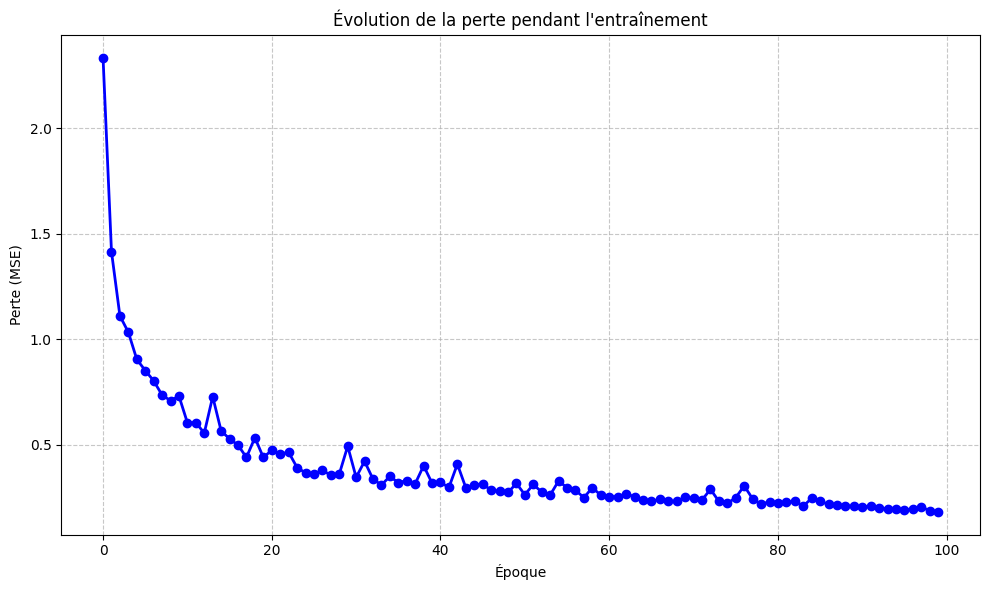

In [42]:
import matplotlib.pyplot as plt

# Affichage de la perte
plt.figure(figsize=(10, 6))
plt.plot(losses.detach().numpy(), 'o-', color='blue', linewidth=2)
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()